In [133]:
import os
import argparse
import sys
import json
import pandas as pd
import numpy as np
import nltk
import time
from sklearn.metrics import confusion_matrix
from nltk import word_tokenize
from pandas.core.indexes.base import Index
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_validate, cross_val_score, cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support, make_scorer, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import pickle
import random
#import somef
import seaborn as sns
#from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ciuciu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Binary classification corrected

In [159]:
df_train = pd.read_csv('dataset/merged1.csv', sep=';')
df_train_x = df_train['Text']
for i in range(len(df_train_x)):
    df_train_x[i] = df_train_x[i].replace('\n', ' ').replace(',', ' ').lower()
df_train_y = df_train['Label']

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df_train_x, df_train_y, test_size=0.30, random_state=42, stratify=df_train_y)

In [4]:
clf = Pipeline([
    ('vectorizer', CountVectorizer(analyzer="word",
                                   tokenizer=word_tokenize,
                                   max_features=None,
                                   lowercase=True)),
    #('smote', SMOTE(random_state=42)),
    ('classifier', LinearSVC(random_state=42))
])

clf.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(tokenizer=<function word_tokenize at 0x7fd877110160>)),
                ('classifier', LinearSVC(random_state=42))])

In [5]:
y_pred = clf.predict(y_test)

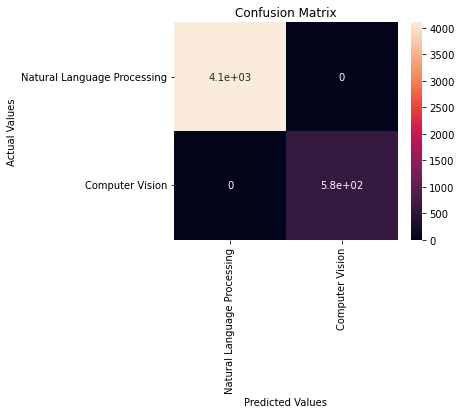

Accuracy :  1.0


In [6]:
cm = confusion_matrix(y_test, y_pred)
y_unique = y_test.unique()
cm_df = pd.DataFrame(cm,
                     index = [y_unique], 
                     columns = [y_unique])#
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()


print("Accuracy : ", metrics.accuracy_score(y_test, y_pred))

In [7]:
x = random.randrange(0, 1000)
print(x)
X = X_test.iloc[[x]]
#print(X)
y = y_test.iloc[x]
y_pred  = clf.predict(X)
print(y, y_pred[0])

193
Natural Language Processing Natural Language Processing


In [8]:
df_train_all = pd.read_csv('dataset/train_all.csv', sep=';')
df_train_all_x = df_train_all['Text']
for i in range(len(df_train_all_x)):
    df_train_all_x[i] = df_train_all_x[i].replace('\n', ' ').replace(',', ' ').lower()
df_train_all_y = df_train_all['Label']
print(df_train_all.shape)

(25828, 3)


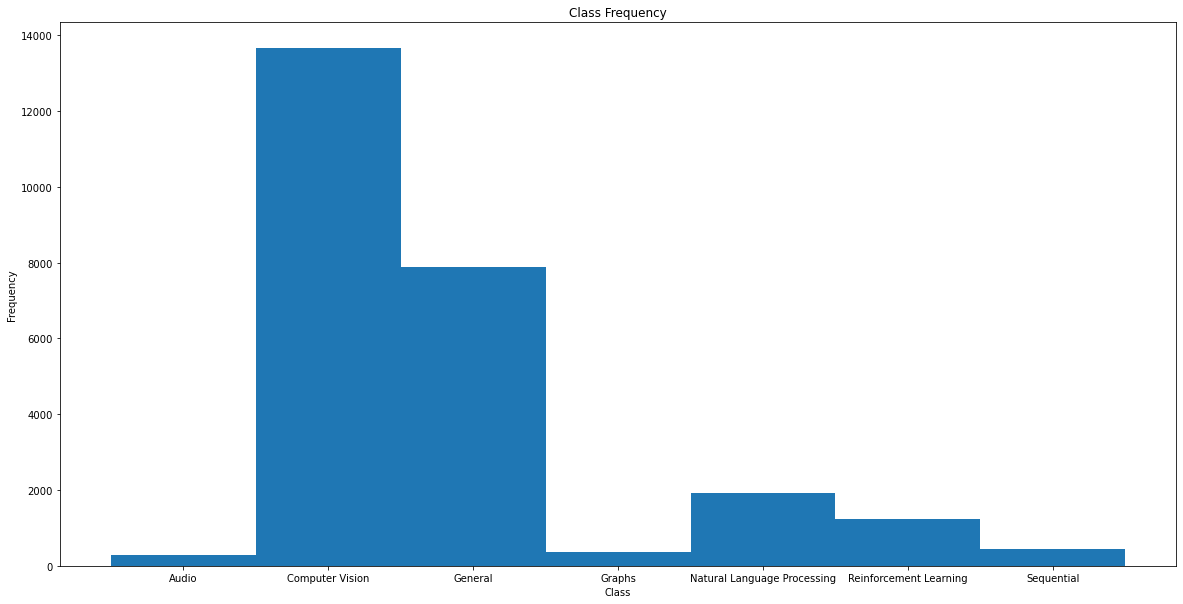

In [9]:
unique, counts = np.unique(df_train_all_y, return_counts=True)
plt.figure(figsize=(20,10))
plt.bar(unique, counts, 1)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [10]:
unique, counts = np.unique(df_train_all_y, return_counts=True)
print(unique)
print(counts)

['Audio' 'Computer Vision' 'General' 'Graphs'
 'Natural Language Processing' 'Reinforcement Learning' 'Sequential']
[  286 13664  7896   363  1928  1237   454]


# Nice version

In [160]:
class DataframeContainer:
    def __init__(self, name):
        self.name = name
        self.dataframe = pd.read_csv('dataset/merged1.csv', sep=';')
        
    def filter_dataframe(self):
        count = 0
        for ind, row in self.dataframe.iterrows():
            if self.name != str(row['Label']):
                count += 1
                row['Label'] = 'Other'
                row['Text'] = row['Text'].replace('\n', ' ').replace(',', ' ').lower()
        print(f'{self.name} filtered {count} rows')  

    def separate_x_y(self):
        self.df_X, self.df_y = self.dataframe['Text'], self.dataframe['Label']
        unique, counts = np.unique(self.df_y , return_counts=True)
        plt.bar(unique, counts, 1)
        plt.title('Class Frequency')
        plt.xlabel('Class')
        plt.ylabel('Frequency')
        plt.show()
    
    def split_train_test(self, test_size = 0.2, random_state = 42):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.df_X, self.df_y, test_size=test_size, random_state=random_state, stratify=self.df_y)

    def clf_fit(self):
        self.clf = Pipeline([
            ('vectorizer', CountVectorizer(analyzer="word",
                                           tokenizer=word_tokenize,
                                           max_features=None,
                                           lowercase=True)),
            ('undersample', RandomUnderSampler(sampling_strategy='majority')),
            ('classifier', LinearSVC(random_state=42))
        ])
        self.clf.fit(self.X_train, self.y_train)
        print(f'{self.name} clf fit done')
        
    def predict(self):
        self.y_pred = self.clf.predict(self.X_test)

    def confusion_matrix(self):
        y_unique = self.y_test.unique()
        cm = confusion_matrix(self.y_test, self.y_pred, labels=y_unique)
        cm_df = pd.DataFrame(cm, index = [y_unique], columns = [y_unique])
        plt.figure(figsize=(5,4))
        sns.heatmap(cm_df, annot=True, fmt='d')
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Values')
        plt.xlabel('Predicted Values')
        plt.show()
        print(f"Accuracy {self.name} : {metrics.accuracy_score(self.y_test, self.y_pred)}")
        m = metrics.precision_recall_fscore_support(self.y_test, self.y_pred, average='macro')
        print(f"Precision {self.name} : {m[0]} \nRecall {self.name} : {m[1]} \nF1-score {self.name} : {m[2]}")

    def cv(self):
        scores = cross_val_score(self.clf, self.df_X, self.df_y, cv=3, scoring='f1')
        print(scores)
    
    def save_pickle(self):
        filename = self.name + '.sav'
        pickle.dump(self.clf, open(filename, 'wb'))

Audio filtered 37034 rows


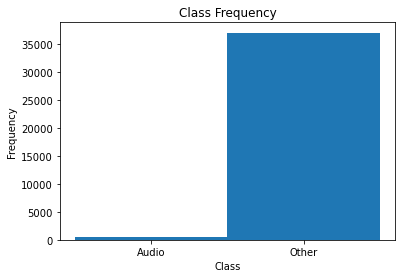

Computer Vision filtered 18699 rows


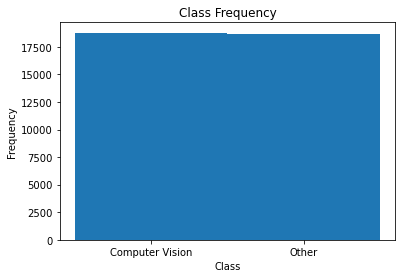

General filtered 25598 rows


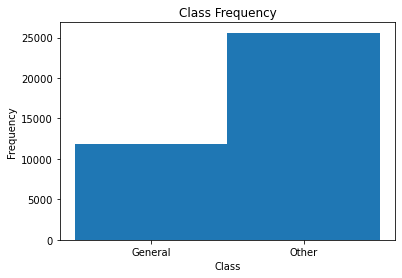

Graphs filtered 36866 rows


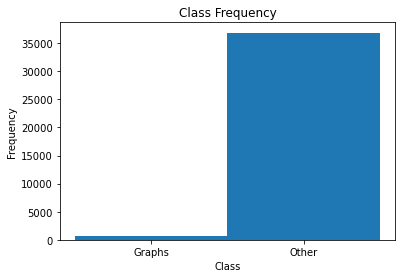

Natural Language Processing filtered 34376 rows


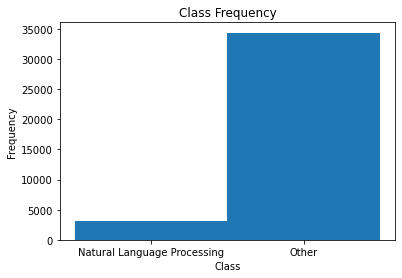

Reinforcement Learning filtered 35587 rows


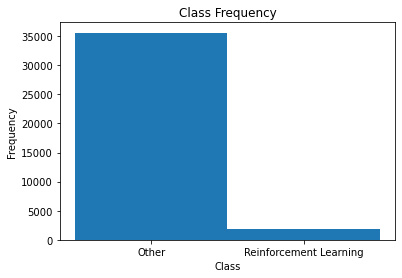

Sequential filtered 36702 rows


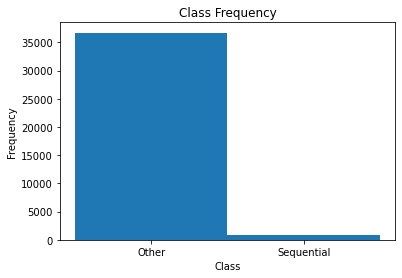

In [161]:
names_list = ["Audio", "Computer Vision", "General", "Graphs", "Natural Language Processing", "Reinforcement Learning", "Sequential"]
#names_list = ["Graphs"]
dataframecontainers_list = [DataframeContainer(name) for name in names_list]
for container in dataframecontainers_list:
    container.filter_dataframe()
    container.separate_x_y()
    container.split_train_test()

In [162]:
for container in dataframecontainers_list:
    container.clf_fit()

Audio clf fit done
Computer Vision clf fit done
General clf fit done
Graphs clf fit done
Natural Language Processing clf fit done
Reinforcement Learning clf fit done
Sequential clf fit done


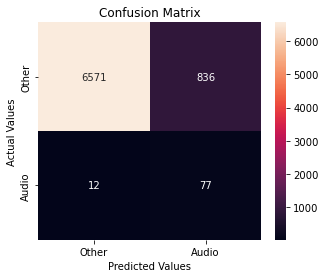

Accuracy Audio : 0.8868729989327642
Precision Audio : 0.5412572361449444 
Recall Audio : 0.8761511658422112 
F1-score Audio : 0.5465389449835141


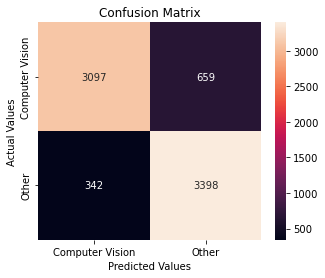

Accuracy Computer Vision : 0.866462113127001
Precision Computer Vision : 0.8690585945851723 
Recall Computer Vision : 0.8665517702869705 
F1-score Computer Vision : 0.8662464483809681


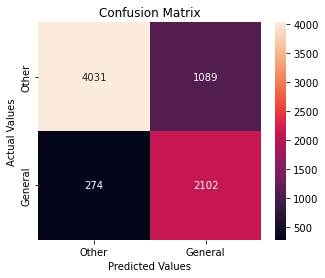

Accuracy General : 0.8181696905016008
Precision General : 0.7975403746964005 
Recall General : 0.8359924110900674 
F1-score General : 0.8052744884000498


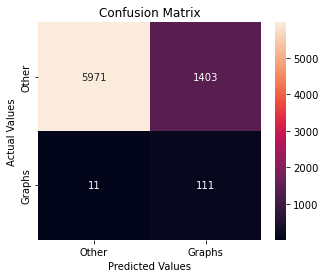

Accuracy Graphs : 0.8113660618996799
Precision Graphs : 0.5357384350320887 
Recall Graphs : 0.8597864895267822 
F1-score Graphs : 0.5149134002757658


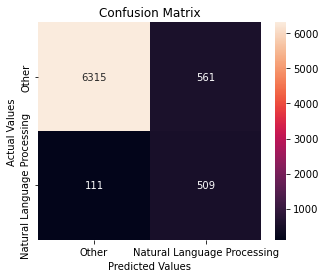

Accuracy Natural Language Processing : 0.9103521878335112
Precision Natural Language Processing : 0.7292136792411669 
Recall Natural Language Processing : 0.8696898046501154 
F1-score Natural Language Processing : 0.7759240724578499


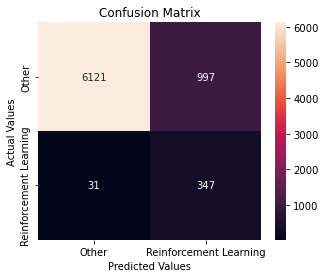

Accuracy Reinforcement Learning : 0.8628601921024547
Precision Reinforcement Learning : 0.6265727560530063 
Recall Reinforcement Learning : 0.8889609916583786 
F1-score Reinforcement Learning : 0.6627758858060107


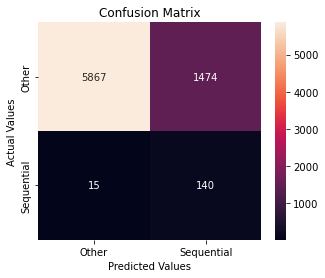

Accuracy Sequential : 0.8013607257203842
Precision Sequential : 0.5420954315499327 
Recall Sequential : 0.8512178616783334 
F1-score Sequential : 0.5228373467663685


In [163]:
for container in dataframecontainers_list:
    container.predict()
    container.confusion_matrix()
    #container.cv()

In [164]:
for container in dataframecontainers_list:
    container.save_pickle()

In [17]:
def finaltest(df_train_all):
    pos = 0
    df_train_all_x = df_train_all['Text']
    for i in range(len(df_train_all_x)):
        df_train_all_x[i] = df_train_all_x[i].replace('\n', ' ').replace(',', ' ').lower()
    df_train_all_y = df_train_all['Label']
    for x in range(df_train_all_x.shape[0]):
        X = df_train_all_x.iloc[[x]]
        y = df_train_all_y.iloc[x]
        #predictions = [dataframe.clf.predict(X)[0] for dataframe in dataframecontainers_list]
        for dataframecontainer in dataframecontainers_list:
            #print(dataframecontainer.name)
            prediction = dataframecontainer.clf.predict(X)[0]
         #   p.append(prediction)
            if prediction != 'Other' and prediction == y:
                pos += 1
                break
        #print(p, y)
    print(pos/df_train_all_x.shape[0])
        
finaltest(df_train_all)

0.9969025863404057


# First try

In [18]:
df_audio = pd.read_csv('dataset/train_all.csv', sep=';')
count = 0
for ind, row in df_audio.iterrows():
    if str('Audio') != str(row['Label']):
        row['Label'] = 'Other'
        count += 1
print('Audio done', count)
        
df_cv = pd.read_csv('dataset/train_all.csv', sep=';')
count = 0
for ind, row in df_cv.iterrows():
    if str('Computer Vision') != str(row['Label']):
        count += 1
        row['Label'] = 'Other'
print('Computer vision done', count)
        
df_general = pd.read_csv('dataset/train_all.csv', sep=';')
count = 0
for ind, row in df_general.iterrows():
    if str('General') != str(row['Label']):
        row['Label'] = 'Other'
        count += 1
print('General done', count)
        
df_graphs = pd.read_csv('dataset/train_all.csv', sep=';')
count = 0
for ind, row in df_graphs.iterrows():
    if str('Graphs') != str(row['Label']):
        row['Label'] = 'Other'
        count += 1
print('Graphs done', count)
        
df_nlp = pd.read_csv('dataset/train_all.csv', sep=';')
count = 0
for ind, row in df_nlp.iterrows():
    if str('Natural Language Processing') != str(row['Label']):
        row['Label'] = 'Other'
        count += 1
print('NLP done', count)
        
df_rl = pd.read_csv('dataset/train_all.csv', sep=';')
count = 0
for ind, row in df_rl.iterrows():
    if str('Reinforcement Learning') != str(row['Label']):
        count += 1 
        row['Label'] = 'Other'
print('RL done', count)        

df_sequential = pd.read_csv('dataset/train_all.csv', sep=';')
count = 0
for ind, row in df_sequential.iterrows():
    if str('Sequential') != str(row['Label']):
        count += 1
        row['Label'] = 'Other'
print('Seqential done', count)

Audio done 25542
Computer vision done 12164
General done 17932
Graphs done 25465
NLP done 23900
RL done 24591
Seqential done 25374


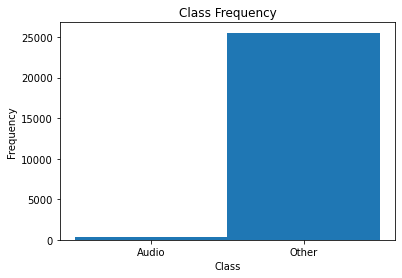

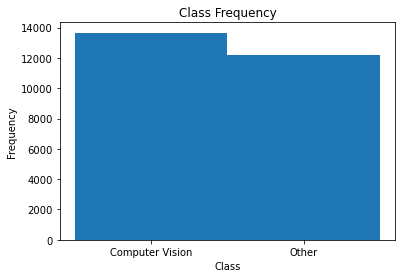

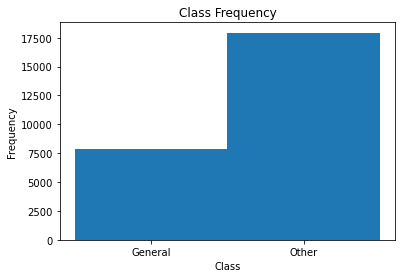

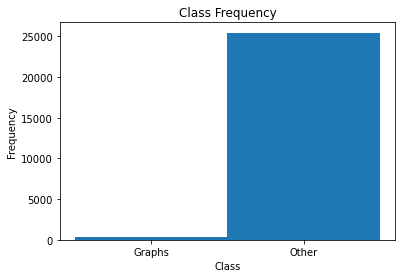

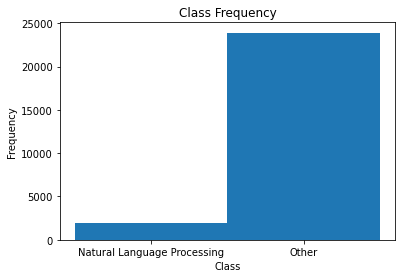

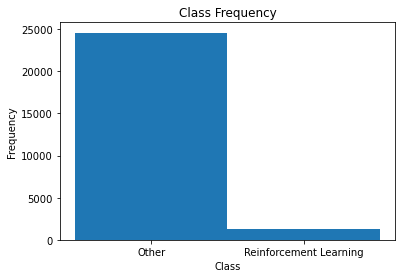

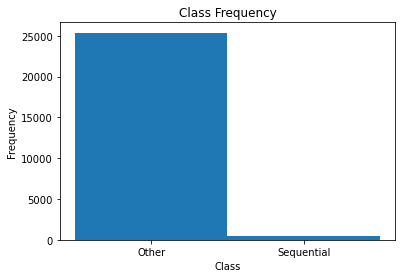

In [19]:
df_audio_x = df_audio['Text']
df_audio_y = df_audio['Label']

unique, counts = np.unique(df_audio_y , return_counts=True)
plt.bar(unique, counts, 1)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


df_cv_x = df_cv['Text']
df_cv_y = df_cv['Label']

unique, counts = np.unique(df_cv_y , return_counts=True)
plt.bar(unique, counts, 1)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


df_general_x = df_general['Text']
df_general_y = df_general['Label']

unique, counts = np.unique(df_general_y , return_counts=True)
plt.bar(unique, counts, 1)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


df_graphs_x = df_graphs['Text']
df_graphs_y = df_graphs['Label']

unique, counts = np.unique(df_graphs_y , return_counts=True)
plt.bar(unique, counts, 1)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


df_nlp_x = df_nlp['Text']
df_nlp_y = df_nlp['Label']

unique, counts = np.unique(df_nlp_y , return_counts=True)
plt.bar(unique, counts, 1)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


df_rl_x = df_rl['Text']
df_rl_y = df_rl['Label']

unique, counts = np.unique(df_rl_y , return_counts=True)
plt.bar(unique, counts, 1)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


df_sequential_x = df_sequential['Text']
df_sequential_y = df_sequential['Label']

unique, counts = np.unique(df_sequential_y , return_counts=True)
plt.bar(unique, counts, 1)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [20]:
X_audio_train, X_audio_test, y_audio_train, y_audio_test = train_test_split(df_audio_x, df_audio_y, test_size=0.30, random_state=42, stratify=df_audio_y)

X_cv_train, X_cv_test, y_cv_train, y_cv_test = train_test_split(df_cv_x, df_cv_y, test_size=0.30, random_state=42, stratify=df_cv_y)

X_general_train, X_general_test, y_general_train, y_general_test = train_test_split(df_general_x, df_general_y, test_size=0.30, random_state=42, stratify=df_general_y)

X_graphs_train, X_graphs_test, y_graphs_train, y_graphs_test = train_test_split(df_graphs_x, df_graphs_y, test_size=0.30, random_state=42, stratify=df_graphs_y)

X_nlp_train, X_nlp_test, y_nlp_train, y_nlp_test = train_test_split(df_nlp_x, df_nlp_y, test_size=0.30, random_state=42, stratify=df_nlp_y)

X_rl_train, X_rl_test, y_rl_train, y_rl_test = train_test_split(df_rl_x, df_rl_y, test_size=0.30, random_state=42, stratify=df_rl_y)

X_sequential_train, X_sequential_test, y_sequential_train, y_sequential_test = train_test_split(df_sequential_x, df_sequential_y, test_size=0.30, random_state=42, stratify=df_sequential_y)

In [21]:
clf_audio = Pipeline([
    ('vectorizer', CountVectorizer(analyzer="word",
                                   tokenizer=word_tokenize,
                                   max_features=None,
                                   lowercase=True)),
    #('smote', SMOTE(random_state=42)),
    ('classifier', LinearSVC(random_state=42))
])
clf_audio.fit(X_audio_train, y_audio_train)
print('Audio done')


clf_cv = Pipeline([
    ('vectorizer', CountVectorizer(analyzer="word",
                                   tokenizer=word_tokenize,
                                   max_features=None,
                                   lowercase=True)),
    #('smote', SMOTE(random_state=42)),
    ('classifier', LinearSVC(random_state=42))
])
clf_cv.fit(X_cv_train, y_cv_train)
print('CV done')


clf_general = Pipeline([
    ('vectorizer', CountVectorizer(analyzer="word",
                                   tokenizer=word_tokenize,
                                   max_features=None,
                                   lowercase=True)),
    #('smote', SMOTE(random_state=42)),
    ('classifier', LinearSVC(random_state=42))
])
clf_general.fit(X_general_train, y_general_train)
print('General done')


clf_graphs = Pipeline([
    ('vectorizer', CountVectorizer(analyzer="word",
                                   tokenizer=word_tokenize,
                                   max_features=None,
                                   lowercase=True)),
    #('smote', SMOTE(random_state=42)),
    ('classifier', LinearSVC(random_state=42))
])
clf_graphs.fit(X_graphs_train, y_graphs_train)
print('Graphs done')


clf_nlp = Pipeline([
    ('vectorizer', CountVectorizer(analyzer="word",
                                   tokenizer=word_tokenize,
                                   max_features=None,
                                   lowercase=True)),
    #('smote', SMOTE(random_state=42)),
    ('classifier', LinearSVC(random_state=42))
])
clf_nlp.fit(X_nlp_train, y_nlp_train)
print('NLP done')


clf_rl = Pipeline([
    ('vectorizer', CountVectorizer(analyzer="word",
                                   tokenizer=word_tokenize,
                                   max_features=None,
                                   lowercase=True)),
    #('smote', SMOTE(random_state=42)),
    ('classifier', LinearSVC(random_state=42))
])
clf_rl.fit(X_rl_train, y_rl_train)
print('RL done')


clf_sequential = Pipeline([
    ('vectorizer', CountVectorizer(analyzer="word",
                                   tokenizer=word_tokenize,
                                   max_features=None,
                                   lowercase=True)),
    #('smote', SMOTE(random_state=42)),
    ('classifier', LinearSVC(random_state=42))
])
clf_sequential.fit(X_sequential_train, y_sequential_train)
print('Sequential done')

Audio done
CV done
General done
Graphs done
NLP done
RL done
Sequential done


In [22]:
y_audio_pred = clf_audio.predict(X_audio_test)

y_cv_pred = clf_cv.predict(X_cv_test)

y_general_pred = clf_general.predict(X_general_test)

y_graphs_pred = clf_graphs.predict(X_graphs_test)

y_nlp_pred = clf_nlp.predict(X_nlp_test)

y_rl_pred = clf_rl.predict(X_rl_test)

y_sequential_pred = clf_sequential.predict(X_sequential_test)

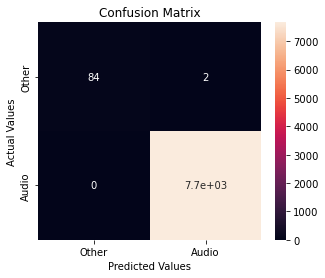

Accuracy audio :  0.9997419021809266


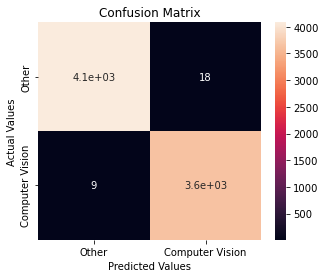

Accuracy cv :  0.9965156794425087


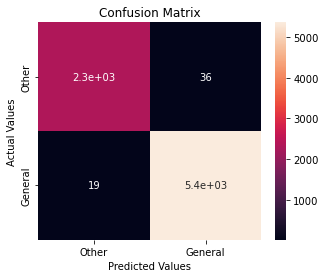

Accuracy general :  0.9929023099754807


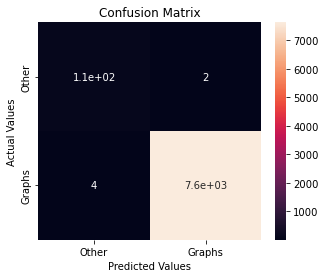

Accuracy graphs :  0.9992257065427798


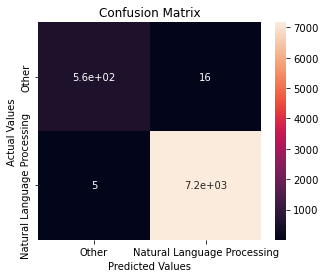

Accuracy nlp :  0.997289972899729


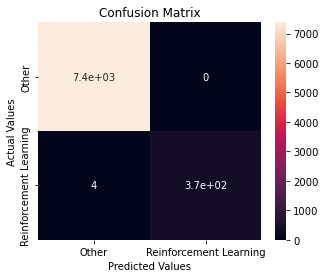

Accuracy rl :  0.9994838043618531


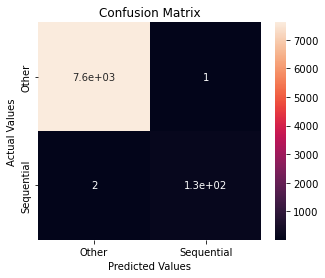

Accuracy sequential :  0.9996128532713898


In [23]:
cm = confusion_matrix(y_audio_test, y_audio_pred)
y_audio_unique = y_audio_test.unique()
cm_df = pd.DataFrame(cm,
                     index = [y_audio_unique], 
                     columns = [y_audio_unique])#
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
print("Accuracy audio : ", metrics.accuracy_score(y_audio_test, y_audio_pred))


cm = confusion_matrix(y_cv_test, y_cv_pred)
y_cv_unique = y_cv_test.unique()
cm_df = pd.DataFrame(cm,
                     index = [y_cv_unique], 
                     columns = [y_cv_unique])#
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
print("Accuracy cv : ", metrics.accuracy_score(y_cv_test, y_cv_pred))


cm = confusion_matrix(y_general_test, y_general_pred)
y_general_unique = y_general_test.unique()
cm_df = pd.DataFrame(cm,
                     index = [y_general_unique], 
                     columns = [y_general_unique])#
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
print("Accuracy general : ", metrics.accuracy_score(y_general_test, y_general_pred))


cm = confusion_matrix(y_graphs_test, y_graphs_pred)
y_graphs_unique = y_graphs_test.unique()
cm_df = pd.DataFrame(cm,
                     index = [y_graphs_unique], 
                     columns = [y_graphs_unique])#
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
print("Accuracy graphs : ", metrics.accuracy_score(y_graphs_test, y_graphs_pred))


cm = confusion_matrix(y_nlp_test, y_nlp_pred)
y_nlp_unique = y_nlp_test.unique()
cm_df = pd.DataFrame(cm,
                     index = [y_nlp_unique], 
                     columns = [y_nlp_unique])#
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
print("Accuracy nlp : ", metrics.accuracy_score(y_nlp_test, y_nlp_pred))


cm = confusion_matrix(y_rl_test, y_rl_pred)
y_rl_unique = y_rl_test.unique()
cm_df = pd.DataFrame(cm,
                     index = [y_rl_unique], 
                     columns = [y_rl_unique])#
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
print("Accuracy rl : ", metrics.accuracy_score(y_rl_test, y_rl_pred))


cm = confusion_matrix(y_sequential_test, y_sequential_pred)
y_sequential_unique = y_sequential_test.unique()
cm_df = pd.DataFrame(cm,
                     index = [y_sequential_unique], 
                     columns = [y_sequential_unique])#
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
print("Accuracy sequential : ", metrics.accuracy_score(y_sequential_test, y_sequential_pred))

In [24]:
pos = 0
for x in range(df_train_all_x.shape[0]):
    predictions = []
    X = df_train_all_x.iloc[[x]]
    y = df_train_all_y.iloc[x]
    predictions.append(clf_audio.predict(X)[0])
    predictions.append(clf_cv.predict(X)[0])
    predictions.append(clf_general.predict(X)[0])
    predictions.append(clf_graphs.predict(X)[0])
    predictions.append(clf_nlp.predict(X)[0])
    predictions.append(clf_rl.predict(X)[0])
    predictions.append(clf_sequential.predict(X)[0])
    for i in predictions:
        if i != 'Other':
            if i == y:
                pos += 1
                continue
print(pos/df_train_all_x.shape[0])

KeyboardInterrupt: 